# Ensemble Learning and Random Forests

Suppose you ask a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert's answer. This is called the *wisdom of the crowd*. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an *ensemble*; thus, this technique is called *Ensemble Learning*, and an Ensemble Learning algorithm is called an *Ensemble method*.

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, you just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a Random Forest, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

Moreover, you will often use Ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor. In fact, the winning solutions in Machine Learning competitions often involve several Ensemble methods.

In this chapter we will discuss the most popular Ensemble methods, including *bagging*, *boosting*, *stacking*, and a few others. We will also explore Random Forests.

## Voting Classifiers

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifiers, and perhaps a few more.

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a *hard voting* classifier.

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the esemble. In fact, even if each classifier is a *weak learner* (meaning it does only slighly better than random guessing), the ensemble can still be a *strong learner* (achieving high accuracy, provided there are a sufficient number of weak learners and they are sufficiently diverse.

How is this possible? The following analogy can help shed some light on this mistery. Suppose you have a slighly biased coin that has a 51% chance of coming up heads, and 49% chance of coming up tails. If you toss it 1000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g. with 10000 tosses, the probability climbs over 97%). This is due to the *law of large number*: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads.

Similarly, suppose you build an esemble containing 1000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data. They are likely to make the same type of errors, so there will be many majority votes for the wrong class, reducing the ensemble's accuracy.

**Note**:

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.

The following code creates nad trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset).

In [110]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import make_moons
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
X, y = make_moons(n_samples = 100) # create a dataset of 100 points

train = np.random.randint(low = 0, high = 99, size = 80) # shuffled indexes for training set
test = np.array([i for i in range(100) if i not in train])

X_train, y_train = X[train,:], y[train]
X_test, y_test = X[test,:], y[test] 

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting = "hard"
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFo...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

Let's look at each classifier accuracy on the test set:

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8571428571428571
RandomForestClassifier 1.0
SVC 0.9523809523809523
VotingClassifier 0.9523809523809523


There you have it! the voting classifier slightly outperforms all the individual classifiers(actually it doesn't!).

If all classifier are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called *soft voting*. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace voting = "hard" with voting = "soft" and ensure that all classifiers can estimate class probabilities. This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method). 

## Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. 

When sampling is performed *with* replacement, this method is called *bagging* (short for *boostrap aggregating*). 

When sampling is performed *without replacement*, it is called *pasting*.

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. 

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the *statistical mode* (i.e. the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predidctor trained on the original training set. 

Predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.

### Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier class (or BaggingRegressor for regression). The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap = False). 

The n-jobs parameter tells Scikit-Learn the number of CPU cores to use fro training and predictions (-1 tells Scikit-Learn to use all available cores):

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier



bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 80, bootstrap = True, n_jobs = 7)
#if False:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

**Note** 

The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e. if it has a predict_proba() method), which is the case with Decision Trees classifiers.

The ensemble's predictions will likely generalize much better than a single Decision Tree's predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of erros on the training set, but the decision boundary is less irregular).

Bootstrapping introduces a bit more diversity in the subset that each predictor is trained on; so bagging ends up with a slighly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble's variance is reduced. Overall, bagging often results in better models, which explains why it is generally preferred. However, if you have spare time and CPU power you can use cross-validation to evaluate both bagging and pasting and select the one that works best.

### Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples m training instances with replacement (bootstrap = True), where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called *out-of-bag* (oob) instances. Note that they are not the same 37% for all predictors. 

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, you can set oob_score = True when creating a BaggingClassifier to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the oob_score_ variable:

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = 1, oob_score = True 
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9875

Let's compare the oob evaluation to the evaluation on the test set:

In [6]:
y_pred  = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

Close enough!

The oob decision function for each training instance is also available through the oob_decision_function_ variable. In this case (since the base estimator has a predict_proba() method) the decision function returns the class probabilities for each training instance. For example, the oob evaluation estimates that the first training instance has a 68.25% probability of belonging to the positive class (and 31.75% of belonging to the negative class): 

In [49]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.96216216, 0.03783784],
       [0.        , 1.        ],
       [0.2320442 , 0.7679558 ],
       [0.56097561, 0.43902439],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.05232558, 0.94767442],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.0821256 , 0.9178744 ],
       [0.99487179, 0.00512821],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.35555556, 0.64444444],
       [1.        , 0.        ],
       [0.48901099, 0.51098901],
       [0.88484848, 0.11515152],
       [0.11167513, 0.88832487],
       [0.05325444, 0.94674556],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.

## Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. This is controlled by two hyperparameters: max_features and bootstrap_features. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features.

This is particularly useful when you are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called the *Random Patches* method. Keeping all training instances (i.e. bootstrap = False, and max_samples = 1.0) but sampling features (i.e. bootstrap_features = True and/or max_features smaller than 1.0) is called the *Random Subspaces* method.

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests

As we have discussed, a Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set. Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class which is more convenient and optimized for Decision Trees (similarly, there is a RandomForestRegressor class for regression tasks). The following code trains a Random Forest classifier with 500 trees (each limited to a maximum 16 nodes), using 7 CPU cores:

In [51]:
rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = 7)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exeptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversitym which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier:

In [52]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter = "random", max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = 7)

### Extra trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible threshold (like regular Decision Trees do).

A forest of such extremely random trees is simply called an *Extremely Randomized Trees* ensemble (or *Extra-Trees* for short). Once again, this trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

You can create an Extra-Trees classifier using Scikit-Learn's ExtraTreesClassifier class. Its API is identical to the RandomForestClassifier class. Similarly, the ExtraTreesRegressor class has the same API as the RandomForestRegressor class.

**Note**:

It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation (and tuning the hyperparameters using grid-search).

### Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature's importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all tree in the forest). More precisley, it is a weighted average, where each node's weight is equal to the number of training samples that are associated with it.

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the feature_importances_ variable. For example, the following code trains a RandomForestClassifier on the iris dataset and outputs each feature's importance. It seems that the most important features are the petal length and width, while sepal lenght and width are rather unimportant in comparison:

In [7]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = 7)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09758893099075355
sepal width (cm) 0.02379732197134088
petal length (cm) 0.42236406626452927
petal width (cm) 0.456249680773376


Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

## Boosting

*Boosting* (originally called *hypothesis boosting*) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are *AdaBoost* (short for Adaptive Boosting) and *Gradient Boosting*. Let's start with AdaBoost.

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training ainstances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated and so on.

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted trainining set.

**Caution**:

There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.

Let's take a closer look at the AdaBoost algorithm. Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$. A first predictor is trained and its weighted error rate $r_1$ is computed on the training set:

$$ r_j = \frac{\sum_{\substack{i = 1 \\ \hat{y_j^{(i)}} \neq y^{(i)}}}^m w^{(i)}}{\sum_{i = 1}^m w^{(i)}} $$

where $\hat{y_j^{(i)}}$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance.

The predictor's weight $\alpha_j$ is then computed using the equation below, where $\eta$ is the learning rate hyperparameter (defaults to 1). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e. less accurate than random guessing), then its weight will be negative.

$$ \alpha_j = \eta log \frac{1- r_j}{r_j}$$

Next the instance weights are updated using the equation below: the misclassified instances are boosted.

for i = 1,2, ..., m


$ w^{(i)} \gets  \begin{cases}
      w^{(i)} \; \text{ if } \hat{y_j^{(i)}} = y^{(i)}\\
      \\
      w^{(i)} exp (\alpha_j) \; \text{ if } \hat{y_j^{(i)}} \neq y^{(i)}
    \end{cases}     $

Then all the instance weights are normalized (i.e. divided by $\sum_{i = 1}^m w^{(i)}$).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor's weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors and weights them using the predictor weights $\alpha_j$. The predicted class it the one that receives the majority of weigthed votes (see equation below):

$$ \hat{y}(x) = \underset{k}{\operatorname{argmax}} \sum_{\substack{j = 1 \\ \hat{y}_j(x) = k}}^N \alpha_j$$  where N is the number of predictors


Scikit-Learn actually uses a multiclass version of AdaBoost called SAMME (which stands for *Stagewise Additive Modeling using a Multiclass Exponential loss function*). When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the predictors can estimate class probabilities (i.e. if they have a predict_proba() method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for "Real"), which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 200  *Decision Stumps* using Scikit-Learn's AdaBoostClassifier class (as you might expect, there is also an AdaBoostRegressor class). A Decision Stump is a Decision Tree with max_depth = 1 -- in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class:

In [8]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = "SAMME.R", learning_rate= 0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

**Note**:

If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.

### Gradient Boosting

Another very popular Boosting algorithm is *Gradient Boosting*. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessors. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the *residual errors* made by the previous predictor.

Let's go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let's fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set):

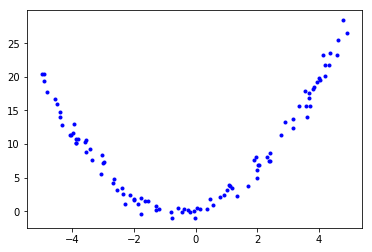

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [111]:
from sklearn.tree import DecisionTreeRegressor

# generate noisy quadratic data
def genQuData(l, h, s):
    X = np.random.uniform(low = l, high = h, size = s) # gen Xs
    eta = np.random.normal(size = s) # gen normal noise
    y = X + X**2 + eta # gen ys
    data = np.c_[X,y] # combine Xs and ys for sorting
    data = data[data[:, 0].argsort()] # sort them
    X, y = data[:,0], data[:,1] # retrieve them
    X = X.reshape(-1, 1) # reshape X into column vector 
    return(X, y)
from matplotlib import pyplot as plt
X, y = genQuData(-5.0, 5.0, 100)
#plt.plot(data[:,0],data[:,1], "b.")
plt.plot(X, y, "b.")
plt.show()

#
tree_reg1 = DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X.reshape(-1, 1), y)

Now train a second DecisionTreeRegressor on the residual errors made by the first predictor:

In [78]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Then we train a third regressor on the residual errors made by the second predictor:

In [79]:
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Now we have an ensemble containig three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

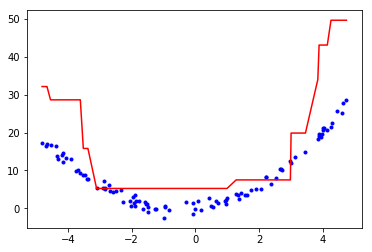

In [81]:
X_new, y_new = genQuData(-5.0, 5.0, 100)
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
x1 = np.linspace(-5.0, 5.0, 100)
plt.plot(X_new, y_new, "b.")
plt.plot(X_new, y_pred, "r-")
plt.show()

A simpler way to train GBRT ensembles is to use Scikit-Learn's GradientBoostingRegressor class. Much like the RandomForestRegressor class it has hyperparameters to control the growth of Decision Trees (e.g. max_depth, min_samples_leaf, and so on), as well as hyperparameters to control the ensemble training, such as the number of trees (n_estimators). The following code createsthe same ensemble as the previous one:

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1 you will need more trees in the ensemble to fit the trianing set, but the predictions will usually generalize better. This is a regularization technique called *shrinkage*.

In order to find the optimal number of trees, you can use early stopping. A simple way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees etc.). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees.

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) # index of the best error --> # of trees used to obtain it

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators = best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=62, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting warm_start = True, which makes Scikit-Learn keep existing trees when the fit() model is called, allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row:

In [117]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break 

1.1511720732849235

The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if subsample = 0.25, then each tree is trained on 25%  of the training instances, selected randomly. As you can probably guess by now, this trades a higher bias for a lower variance. It also speeds up training considerably. This technique is called *Stochastic Gradient Boosting*.

**Note**:

It is possible to use Gradient Boosting with other cost functions, this is controlled by the loss hyperparameter.

It is worth noting that an optimized implementation of Gradient Boosting is available in the popular python library XGBoost, which stands for Extreme Gradient Boosting. XGBoost's API is quite similar to Scikit-Learn's:

In [119]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[11:29:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBoost also offers several nice features, such as automatically taking care of early stopping:

In [122]:
xgb_reg.fit(X_train, y_train,
           eval_set = [(X_val, y_val)], early_stopping_rounds = 2)
y_pred = xgb_reg.predict(X_val)

[11:37:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.1509
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:10.1937
[2]	validation_0-rmse:9.30958
[3]	validation_0-rmse:8.53761
[4]	validation_0-rmse:7.82693
[5]	validation_0-rmse:7.22055
[6]	validation_0-rmse:6.61331
[7]	validation_0-rmse:6.06378
[8]	validation_0-rmse:5.59413
[9]	validation_0-rmse:5.16371
[10]	validation_0-rmse:4.79478
[11]	validation_0-rmse:4.4488
[12]	validation_0-rmse:4.12908
[13]	validation_0-rmse:3.81565
[14]	validation_0-rmse:3.55086
[15]	validation_0-rmse:3.30784
[16]	validation_0-rmse:3.08959
[17]	validation_0-rmse:2.88558
[18]	validation_0-rmse:2.70642
[19]	validation_0-rmse:2.54447
[20]	validation_0-rmse:2.38285
[21]	validation_0-rmse:2.23419
[22]	validation_0-rmse:2.1077
[23]	validation_0-rmse:1.98045
[24]	validation_0-rmse:1.8682
[25]	validation_0-rmse:1.76273
[26]	validation_0-rmse:1.67

## Stacking

The last Ensemble method we will disuss in this chapter is called *stacking* (short for *stacked generalization*). It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an esemble, why don't we train a model to perform this aggregation? See figure below:

![alt text](stacking.PNG "Decision Tree")

Each of the bottom three predictors predicts a different value, and then the final predictor (called a *blender*, or a *meta learner*) takes the predictions as inputs and makes the final prediction.

To train a blender, a common approach is to use a hold-out set. 

First, the training set is split in two subsets. The first subset is used to train the predictors in the first layer.

Next, the first layer predictors are used to make predictions on the second (held-out) set. This ensures that the predictions are "clean", since the predictors never saw these instances during training. Now for each instance in the hold-out set there are three predicted values. We an create a new training set using these predicted values as input features (which makes this new training set three-dimensional), and keeping the target values. The blender is trained on this new training set, so it learns to predict the target value given the first layer's predictions.

It is actually possible to train several different blenders this way (e.g. one using Linear Regression, another uisng Random Forest Regression, and so on): we get a whole layer of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is usced to create the training set to train the third layer (using predictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially.

Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard to roll out your implementation. Alternatively you can use an open source implementation such as brew.